In [23]:
import scipy.io
from scipy.integrate import odeint
import math 
import numpy as np
import matplotlib.pyplot as plt
import theano
%matplotlib inline

theano.config.compute_test_value = 'raise'
theano.config.exception_verbosity= 'high'
THEANO_FLAGS='floatX=float32,optimizer=fast_compile'
theano.config.floatX = 'float64'

In this example we will use PyMC3 to infer the parameters of the Fitzhugh-Nagumo oscillator. It is a simple model that 
generates action potentials. The model is describes as:

\begin{align}
\frac{dV}{dt}&=(V - \frac{V^3}{3} + R)c\\
\frac{dR}{dt}&=\frac{-(V-a+bR)}{c},
\end{align}
where $a$, $b$, $c$ are the model parameters.

We start by defining our ODE solver. In this case we will be using scipy odeint. However, note that we can also wrapp any other solver written in say C++. The point I am trying to drive home is that we are free to call up any model solver as long as it is available in python.

In [24]:
def model_deriv(y, t, param):
    #Define parameters
    a,b,c=param
    
    #define states
    V,R=y
    #define derivatives
    dV_dt=(V-((V**3)/3) +R)*c
    dR_dt=-(V-a+b*R)/c
    return dV_dt,dR_dt
    
def model_sol(param):
    
    y0 = [-1,1]
    time = np.linspace(0, 20, 200)
    solution = odeint(model_deriv, y0, time, args=(param,))
    return np.array(solution)

Having defined our model solver and forward solution, we can generate some synthetic data. We solve the model between [0,20] with 200 equispaced time points and add Gaussian noise with $\sigma=0.5$.

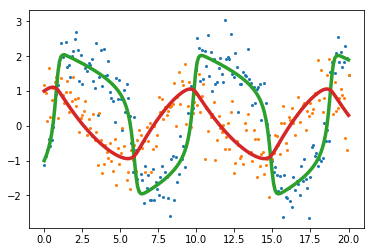

In [25]:
time = np.linspace(0, 20, 200)
sigma=0.5
sol=model_sol([0.2,0.2,3.])
Y=sol+np.random.randn(200,2)*sigma
plt.plot(time,Y,linestyle='None',marker='o',markersize=2)
plt.plot(time,sol,linewidth=3.5)

This is perhaps the most important pat of this example. Here we are defining a custom Theano as_op. Note that we are 
wrapping up the forward solution of our model as an as_op. Thus we tell Theano that we have three parameters each 
being a Theano scalar. The output then is a Theano matrix whose colums are the state vectors.

In [26]:
import theano.tensor as tt
from theano.compile.ops import as_op

@as_op(itypes=[tt.dscalar,tt.dscalar,tt.dscalar], otypes=[tt.dmatrix])
def lotka_ode_sol(param1,param2,param3):
    
    param=[param1,param2,param3]
    sol=model_sol(param)
    
    return sol


Next we define the probabilistic program. The likelihood is a multivariate Normal distribution. The priors are set as follows:
$a\sim \mathcal{\Gamma}(2,1)$, $b\sim \mathcal{N}(0,1)$ and $c\sim \mathcal{U}(0,10)$. In this example we will be estimating the noise standard deviation and thus we put the following prior: $\sigma\sim \mathcal{N}(0,1)$. 

In [ ]:
import pymc3 as pm
from pymc3.step_methods import smc
from tempfile import mkdtemp
from scipy import optimize
basic_model = pm.Model()
n_steps = 20 # Number of MCMC steps for each particle
n_chains = 50 # Number of particles (chains)

with basic_model:

    # Priors for unknown model parameters
    
    
    a = pm.Gamma('a', alpha=2,beta=1, transform=None)
    b = pm.Normal('b', mu=0, sd=1)
    c = pm.Uniform('c', lower=0, upper=10, transform=None)
    sigma = pm.Normal('sigma', mu=0, sd=1)


    # Forward model
    
    mu = lotka_ode_sol(a,b,c)
    
    # Likelihood (sampling distribution) of observations
    cov=np.eye(2)*sigma
    Y_obs = pm.MvNormal('Y_obs', mu=mu, cov=cov, observed=Y)

    
    test_folder = mkdtemp(prefix='SMC_TEST')
    
     # Initial points for each of the chains
    start=[{'a':np.random.uniform(0,15,3),'sigma':np.random.uniform(0,2)} for _ in range(n_chains)]
    
    # Call SMC sampler
    trace = smc.sample_smc(n_steps=n_steps,n_chains=n_chains,start=start,progressbar=True,
                           homepath=test_folder,
                           stage=0,tune_interval=5, n_jobs=5,random_seed=21)

c:\program files\anaconda3\envs\deepl\lib\site-packages\pymc3\step_methods\smc.py:480: UserWarning: Warning: SMC is an experimental step method, and not yet recommended for use in PyMC3!
  warnings.warn(EXPERIMENTAL_WARNING)
Argument `step` is None. Auto-initialising step object using given/default parameters.
c:\program files\anaconda3\envs\deepl\lib\site-packages\pymc3\step_methods\smc.py:120: UserWarning: Warning: SMC is an experimental step method, and not yet recommended for use in PyMC3!
  warnings.warn(EXPERIMENTAL_WARNING)
Adding model likelihood to RVs!
Init new trace!
Sample initial stage: ...
Beta: 0.000000 Stage: 0
Initialising chain traces ...
Sampling ...


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000024B0E0CF4A8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x0000024B0EB40D68>], dtype=object)

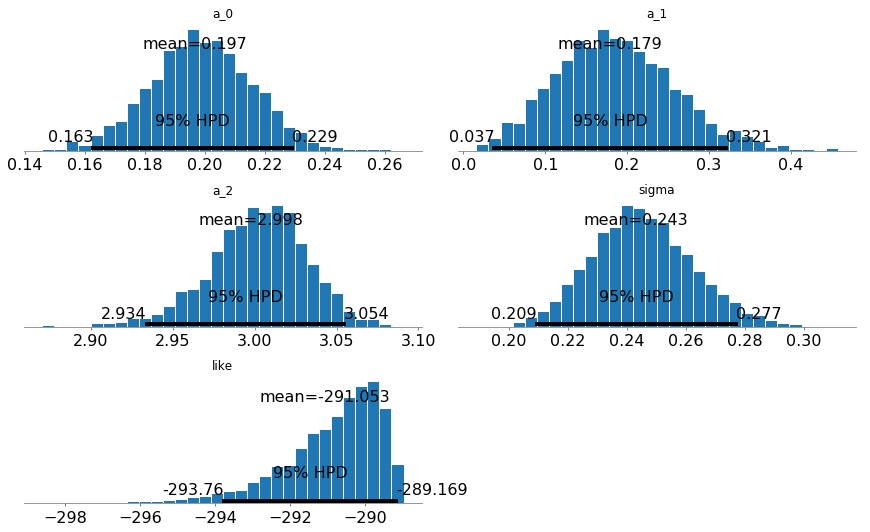

In [7]:
pm.plot_posterior(trace)

In [13]:
summary=pm.df_summary(trace, ['a'])
params=summary['mean']

est_sol=model_sol([params['a__0'],params['a__1'],params['a__2']])
plt.subplot(2,1,1)
plt.plot(Y[:,0],label='Data',linestyle='None',marker='o')
plt.plot(est_sol[:,0],color='k',linewidth=2.5,label='Fit')
plt.plot(sol[:,0],linestyle='--',label='True')
plt.legend(loc='upper right',fontsize='10')

plt.subplot(2,1,2)
plt.plot(Y[:,1])
plt.plot(est_sol[:,1],color='k',linewidth=2.5)
plt.plot(sol[:,1],linestyle='--')


NameError: name 'trace' is not defined

In [40]:
pm.traceplot(trace)

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
0,572.73,3.85,0,0.5,29.11,0,1
1,572.73,3.85,0,0.5,29.11,0,1


In [41]:
trace

<MultiTrace: 1 chains, 10000 iterations, 3 variables>